In [1]:
!pip install fredapi >/dev/null

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()
fred_key = secrets.get_secret("fred-api")



# 1. Create the Fred Object

In [3]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data!

In [4]:
sp_search = fred.search('S&P', order_by='popularity')

In [5]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2022-08-21,2022-08-21,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2022-08-18,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2022-08-19 09:31:02-05:00,94,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2022-08-21,2022-08-21,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2022-05-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2022-07-26 08:02:02-05:00,89,"For more information regarding the index, plea..."
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2022-08-21,2022-08-21,ICE BofA US High Yield Index Effective Yield,1996-12-31,2022-08-18,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2022-08-19 09:31:09-05:00,84,This data represents the effective yield of th...
SP500,SP500,2022-08-21,2022-08-21,S&P 500,2012-08-20,2022-08-19,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-08-19 19:13:40-05:00,82,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2022-08-21,2022-08-21,Real Median Household Income in the United States,1984-01-01,2020-01-01,Annual,A,2020 CPI-U-RS Adjusted Dollars,2020 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2021-09-15 08:45:01-05:00,80,Household data are collected as of March. As ...


# 3. Pull Raw Data

In [6]:
sp500 = fred.get_series(series_id='SP500')

<AxesSubplot:title={'center':'S&P 500'}>

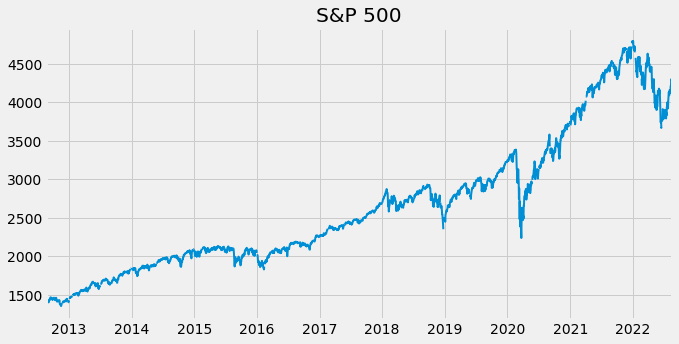

In [7]:
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)

# 4. Pull and Join Multiple Data Series

In [8]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate in')]

In [9]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
unemp_results = pd.concat(all_results, axis=1).drop(['LASMT261982000000003', 'LASMT391746000000003', 'USAURAMS'], axis=1)

In [10]:

unemp_states = unemp_results.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ', '').to_dict()
unemp_states.columns = [id_to_state[c] for c in unemp_states.columns]

In [11]:
# Plot States Unemployment Rates
px.line(unemp_states)


# 5. Pull May 2020 Unemployment Rates per state

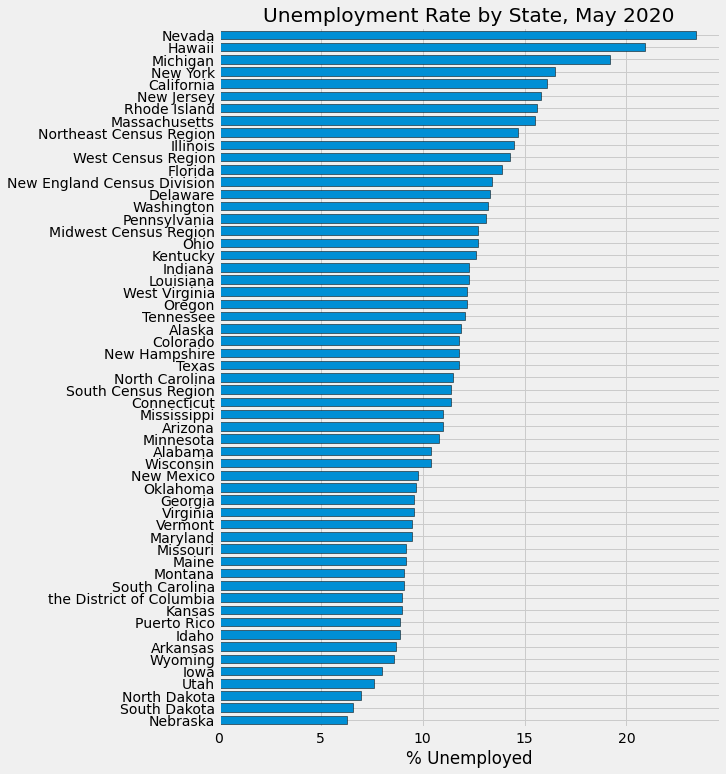

In [12]:
ax = unemp_states.loc[unemp_states.index == '2020-05-01'].T.sort_values('2020-05-01') \
.plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
      title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

# Pull Participation Rate

In [13]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [14]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ', '').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

# Plot Unemployment vs Participation

In [15]:
# Fix DC
unemp_states = unemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

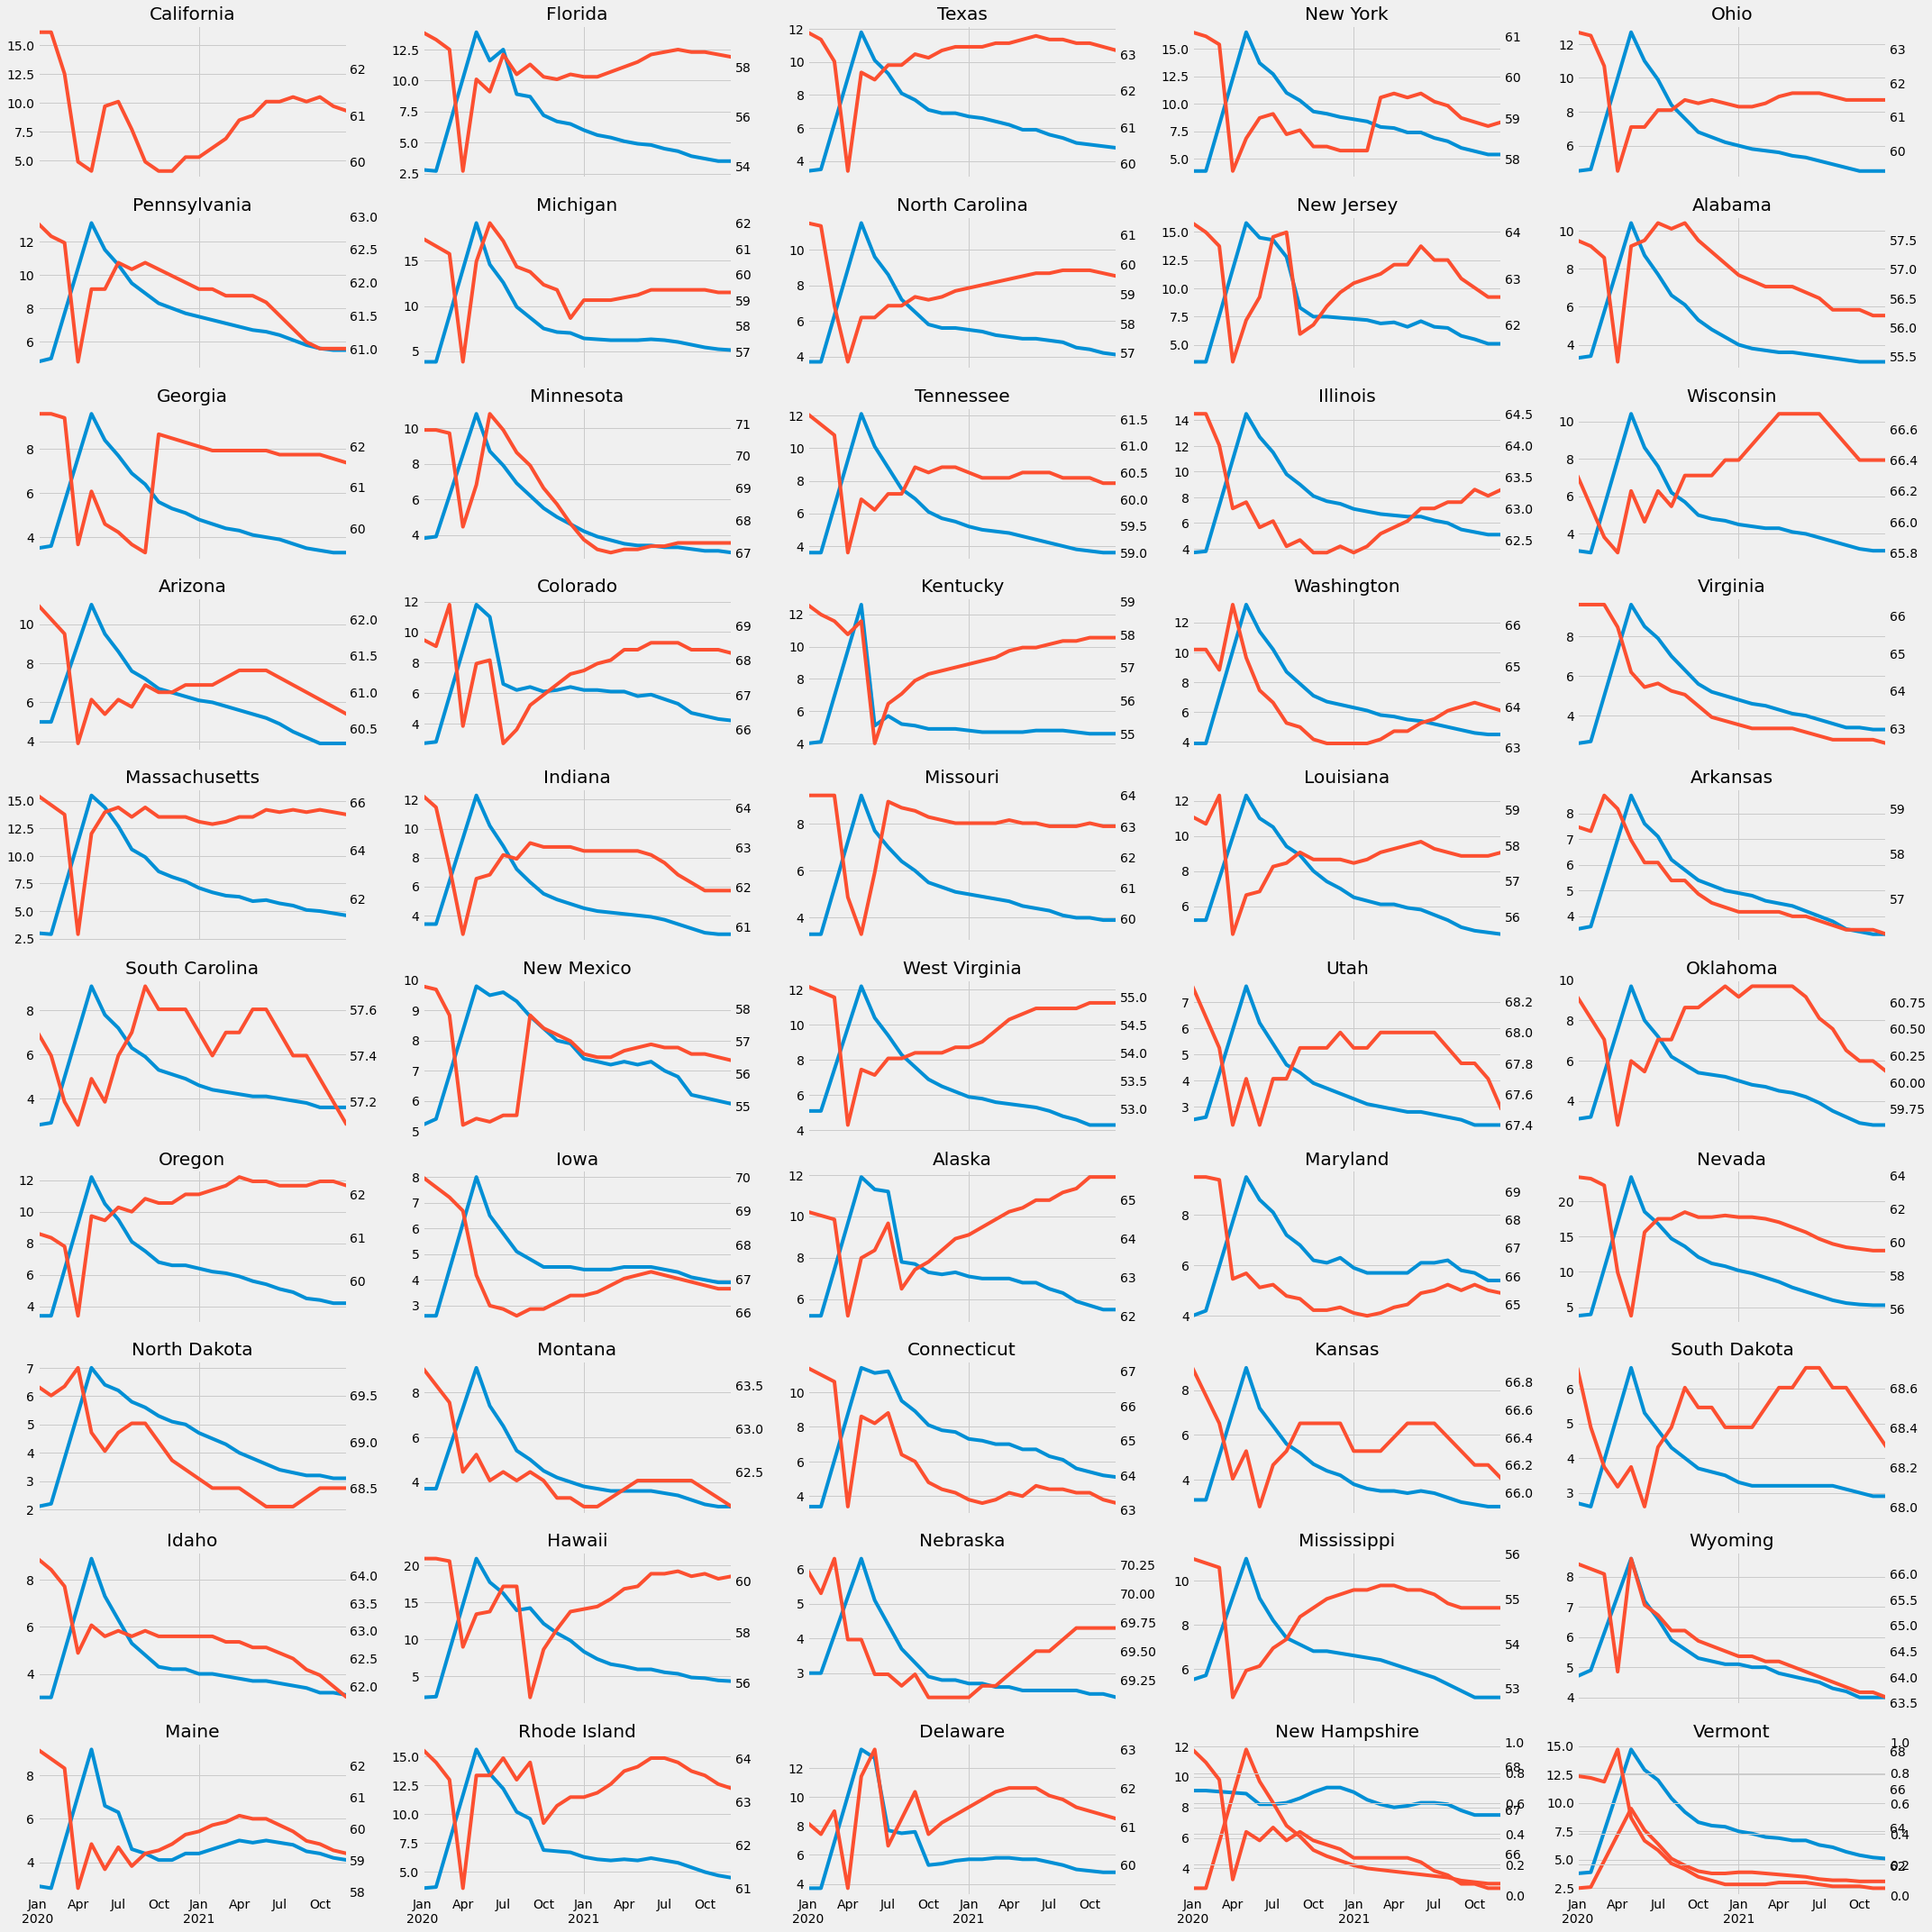

In [16]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in unemp_states.columns:
    try:
        if state == "District Of Columbia":
            continue
        ax2 = axs[i].twinx()
        unemp_states.query('index >= 2020 and index < 2022')[state] \
            .plot(ax=axs[i], label='Unemployment')
        part_states.query('index >= 2020 and index < 2022')[state] \
            .plot(ax=ax2, label='Participation', color=color_pal[1])
        ax2.grid(False)
        axs[i].set_title(state)
        i += 1
    except Exception:
        pass  # To avoid exception for Puerto Rico
plt.tight_layout()
plt.show()
